# MCMC demonstration

Here we'll code up a very simple Metropolis-Hastings algorithm from scratch so we can see how it works.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [58]:
# Generate some 1D "measurements" that reflect the true value plus noise
mu_true = 1
sig_noise = 0.5
SIZE = 10

data = np.random.normal(loc=mu_true, scale=sig_noise, size=SIZE)

In [28]:
def log_likelihood(mu, data, sig):
    '''Calculate the (log) likelihood of the data given proposed mu and noise level sig.'''
    return np.sum(-(data - mu)**2 / (2 * sig**2) + np.log(1 / np.sqrt(2 * np.pi * sig**2)))

def mcmc_mh_uniform(data, mu_min, mu_max, sig, mu_start=0, nsteps=10000):
    '''Markov Chain Monte Carlo, Metropolis-Hastings algorithm, assuming a uniform prior.'''
    trace = []  # store our steps
    mu_i = mu_start
    logL_i = log_likelihood(mu_i, data, sig)  # calculate likelihood of data in starting position
    
    # Metropolis-Hastings loop
    for step in range(nsteps):
        # step 1: propose next step
        mu_n = np.random.uniform(mu_min, mu_max)
        # step 2: calculate likelihood of next step
        logL_n = log_likelihood(mu_n, data, sig)
        # step 3: compare likelihood to current step
        alpha = min(np.exp(logL_n - logL_i), 1)
        # step 4: accept proposed step in proportion to relative likelihood
        if np.random.uniform() < alpha:
            mu_i, logL_i = mu_n, logL_n
        # step 5: place next step (previous or new) on trace and repeat
        trace.append(mu_i)
    return np.array(trace)

In [59]:
trace = mcmc_mh_uniform(data, -2, 3, sig_noise)

In [66]:
DECIMATE = 5
trace_decorr = trace[100::DECIMATE]  # skip burn-in, and decimate to avoid autocorrelation
hist, bins = np.histogram(trace_decorr, bins=20)
bin_cen = 0.5 * (bins[1:] + bins[:-1])
hist = hist / np.sum(hist)

<IPython.core.display.Javascript object>


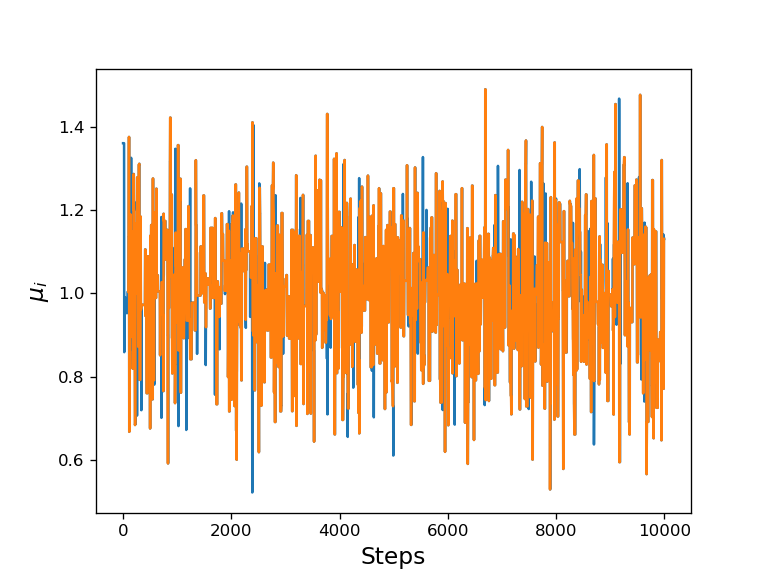

In [68]:
plt.figure()
plt.plot(trace)
plt.plot(100 + DECIMATE * np.arange(trace_decorr.size), trace_decorr)
plt.ylabel('$\mu_i$', fontsize=14)
_ = plt.xlabel('Steps', fontsize=14)

<IPython.core.display.Javascript object>


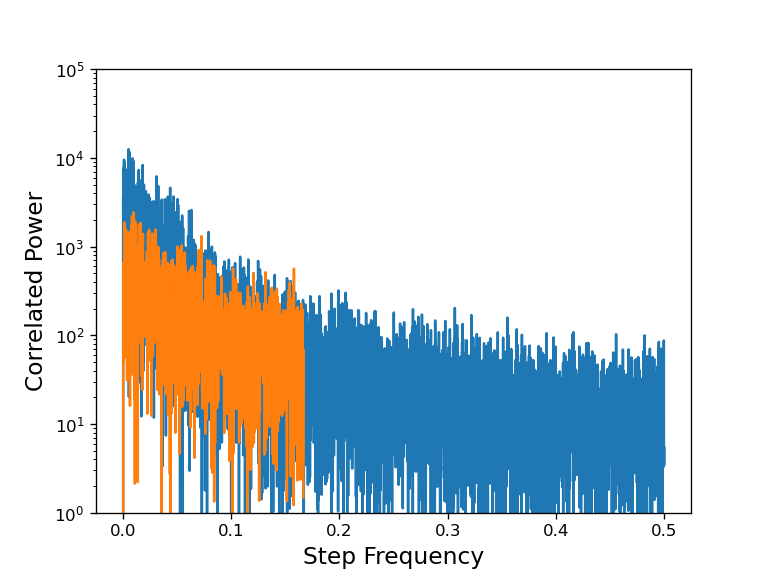

In [77]:
plt.figure()
autocorr = np.abs(np.fft.rfft(trace - np.mean(trace)))**2
autocorr_decorr = np.abs(np.fft.rfft(trace_decorr - np.mean(trace_decorr)))**2
plt.semilogy(np.fft.rfftfreq(trace.size, 1), autocorr)
plt.semilogy(np.fft.rfftfreq(trace_decorr.size, 3), DECIMATE * autocorr_decorr)
plt.ylabel('Correlated Power', fontsize=14)
plt.xlabel('Step Frequency', fontsize=14)
_ = plt.ylim(1e0, 1e5)

<IPython.core.display.Javascript object>


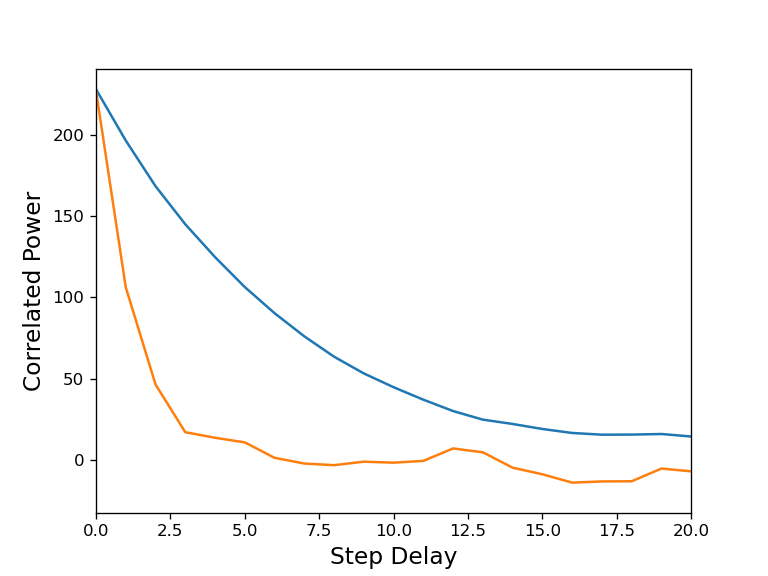

In [88]:
plt.figure()
autocorr = np.fft.irfft(np.abs(np.fft.rfft(trace - np.mean(trace)))**2)
autocorr_decorr = np.fft.irfft(np.abs(np.fft.rfft(trace_decorr - np.mean(trace_decorr)))**2)
plt.plot(autocorr)
plt.plot(DECIMATE * autocorr_decorr)
plt.ylabel('Correlated Power', fontsize=14)
plt.xlabel('Step Delay', fontsize=14)
_ = plt.xlim(0, 20)

<IPython.core.display.Javascript object>


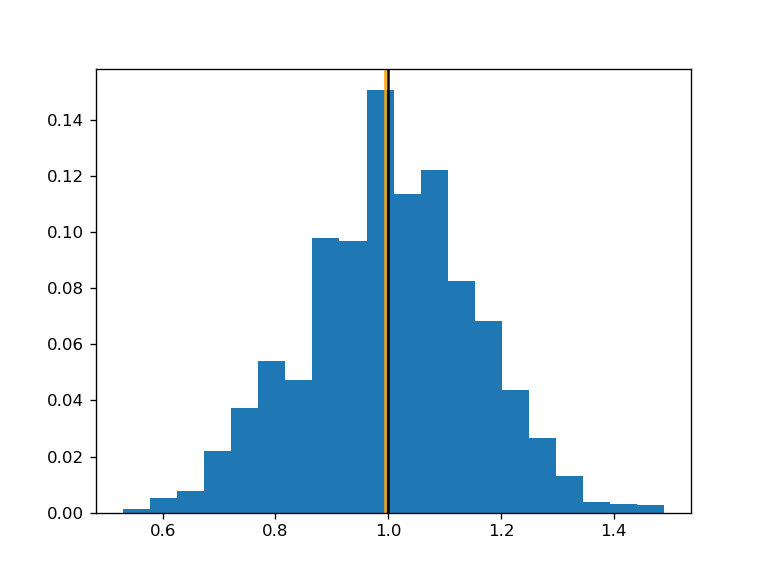

In [62]:
plt.figure()
plt.bar(bin_cen, hist, width=np.median(np.diff(bin_cen)))
plt.axvline(x=mu_true, color='k')
plt.axvline(x=np.mean(data), color='#ffa500')